# Modeling 

## Import Statements 

In [1]:
import os,sys
sys.path.append(os.path.abspath('..'))
from octcv.arrViz import *
from octcv.mdl_lib import *

2025-10-09 16:48:47.292908: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-09 16:48:47.483121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760042927.547006   69689 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760042927.568353   69689 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760042927.726297   69689 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# General
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display as iPyDisplay, Markdown as iPyMD

# Modeling (Tensorflow/Keras)
from keras.models import Sequential
from keras import layers
from keras.layers import Conv3D,Conv2D,Dense,MaxPool2D,MaxPool3D,Flatten,Dropout,\
BatchNormalization,GlobalAveragePooling3D,GlobalAveragePooling2D,ReLU,Input,Add
from keras.metrics import AUC
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import Model as kerasModel
import tensorflow as tf

# Model Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [3]:
# # Setup for Consistent Results
# import random
# seed = 42
# os.environ['PYTHONHASHSEED'] = str(seed)
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
# tf.keras.utils.set_random_seed(seed)

# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# dataset = lambda X,y : tf.data.Dataset.from_tensor_slices((X,y))
# # dataset = dataset.shuffle(buffer_size=len(X), seed=seed, reshuffle_each_iteration=False)

In [4]:
# tf.config.experimental.enable_op_determinism()
# tf.keras.initializers.Zeros()
# constant_initializer = tf.keras.initializers.Constant(value=0.5) # Example: initialize to 0.5

## Loading Modeling/Pre-processed Datasets 

In [5]:
c_test = pd.read_csv('./combined_slices_TEST.csv')
c_train = pd.read_csv('./combined_slices_train.csv')

v_test = pd.read_csv('./volumes_TEST.csv')
v_train = pd.read_csv('./volumes_train.csv')

c_test.shape, c_train.shape, v_test.shape, v_train.shape

((232, 8), (926, 8), (222, 8), (888, 8))

In [6]:
v_train.head(3)

,dx_class,glaucoma,PIN,laterality,left_eye,set,normalized_array,display_volume
0,glaucoma,1,347,OS,1,1,../datasrc/volumesOCT/normalized/p347_Glaucoma...,../datasrc/volumesOCT/POAG-001887-2008-01-31-O...
1,normal,0,560,OD,0,1,../datasrc/volumesOCT/normalized/p560_Normal_O...,../datasrc/volumesOCT/Normal-003164-2012-03-06...
2,glaucoma,1,398,OD,0,1,../datasrc/volumesOCT/normalized/p398_Glaucoma...,../datasrc/volumesOCT/POAG-002184-2011-06-14-O...


In [7]:
c_train.head(3)

,dx_class,glaucoma,PIN,laterality,left_eye,set,normalized_array,display_image
0,glaucoma,1,33,OS,1,1,../datasrc/fundus-oct-composite/normalized/p03...,../datasrc/volumesOCT/bslices/POAG-000275-2010...
1,glaucoma,1,184,OD,0,1,../datasrc/fundus-oct-composite/normalized/p18...,../datasrc/volumesOCT/bslices/POAG-000994-2009...
2,glaucoma,1,184,OS,1,1,../datasrc/fundus-oct-composite/normalized/p18...,../datasrc/volumesOCT/bslices/POAG-000994-2009...


For the case of a unimodal CNN, the entirety of X will be the image data - however, to conserve RAM, will keep as filepaths for now and define a custom function to load the arrays for a given set during training -- this is done via a custom method `octcv.mdl_lib.xY_split()` which returns a `y_label`, `y`, and `X` in which `X` is an instance of the `XVolSet` class, meaning it stores the filepaths and the actual image arrays can be loaded simply via calling the `.load()` method of a given instance -- see help() or source code under `../octcv/mdl_lib.py' for more information.

Additionally, even for grayscale images, `keras` expects an axis for the color channel. So, once the input volumes are loaded, an additional axis of size 1 must be added before passing into model fitting.  In this case, the volumes inherently have shape `(64,128,64)` but will need to be converted to `(64,128,64,1)` - as opposed to color images, which typically have 3 channels, the last dimension has only 1 channel since it is grayscale.

In [8]:
# 3D Volume Dataset
vy_test_labels, vy_test, vX_test = yX_split(v_test)
vy_train_labels, vy_train, vX_train = yX_split(v_train)
print(f"\n3D Volumes - train_test shapes:")
print(f"\tTrain Set(y,X): {vy_test.shape,vX_test.shape}")
print(f"\tTest Set(y,X): {vy_train.shape,vX_train.shape}")

# 2D B-scan & Volume Slice Set
y_test_labels,y_test,X_test = yX_split(c_test)
y_train_labels,y_train,X_train = yX_split(c_train)
print(f"\nCombined 2D Images - train_test shapes:")
print(f"\tTrain Set(y,X): {y_test.shape,X_test.shape}")
print(f"\tTest Set(y,X): {y_train.shape,X_train.shape}\n")


3D Volumes - train_test shapes:
	Train Set(y,X): ((222, 2), (222, 2))
	Test Set(y,X): ((888, 2), (888, 2))

Combined 2D Images - train_test shapes:
	Train Set(y,X): ((232, 2), (232, 2))
	Test Set(y,X): ((926, 2), (926, 2))



In [9]:
# Compare example shapes of X vs x.load()
print(vX_test.shape)
print(vX_test.load().shape)

(222, 2)
(222, 64, 128, 64, 1)


In [10]:
# To verify `normalized` kwarg of `.load()` method works, compare pixel intensity ranges when switched on/off.
print(f"\033[1m TEST DATASET PIXEL INTENSITY RANGES\033[0m\n{'='*40}")
print(f"\n\033[31m\t..loading..\033[0m",end='\r')
print(f"NORMALIZED: \t({vX_test.load(normalized=True).min()}, {vX_test.load(normalized=True).max():.4f})")
print()
print(f"RAW VALUES: \t({vX_test.load(normalized=False).min()}, {vX_test.load(normalized=False).max()})")
print('_'*40)

 TEST DATASET PIXEL INTENSITY RANGES

NORMALIZED: 	(0.0, 0.8980)

RAW VALUES: 	(0, 229)
________________________________________


## Set-Up For Model Saving

In [11]:
# Setup checkpoints to place under callbacks during model fitting to save the model at the best epoch.
checkpoints = []
for i in range(1,4):
    cpt = ModelCheckpoint(f'checkpoints/model_{i}.keras',save_best_only=True,monitor='val_auc',mode='max')
    checkpoints.append(cpt)

In [12]:

def evaluate_model(model,dataset=v_test):
    '''Takes in a model and test set --> generates y_pred and calculates accuracy
    returns accuracy along with y_pred and y_true which can be used for further
    analysis (e.g., confusion matrices).
    '''
    _,y,X = yX_split(dataset)
    y_prob = model.predict(x=X.load(),verbose=0, batch_size=2)
    y_pred = (y_prob >= 0.5).astype(int)[:,0]
    y_true = np.asarray(vy_test).astype(int)[:,0]
    accuracy = (y_pred == y_true).sum() / len(y_pred)
    return accuracy,y_pred,y_true

def cmPlot(dataset=None,model=None,y_pred=None,y_true=None,normalize=None,ax=None):
    '''
    Generates confusion matrix plot for a given model and test dataset.  
    If y_pred & y_true provided, will use that to generate the matrix.
    Otherwise, it will 
        apply the model to the X part of the provided dataset to generate y_pred
        use the y part of the dataset as y_true
        generate confusion matrix and plot

    RETURNS
    -------
    ax    :    `matplotlib.axes._axes.Axes` - the confusion matrix as a subplot (i.e., the ax in fig,ax = matplotlib.pyplot.subplots)
    cm    :    `numpy.ndarray`  -  the output of sklearn.metrics.confusion_matrix()
    (y_true,y_pred)    :    The original class labels (y_true) and model predictions (y_pred).
    
    '''
    if not (y_pred and y_true):
        try:
            _,y_pred,y_true = evaluate_model(dataset=dataset,model=model)
        except:
            raise ValueError("Please pass either dataset and model or y_pred and y_true")
    
    cm = confusion_matrix(y_true,y_pred,labels=[0,1],normalize=normalize)

    if not ax:
        fig,ax = plt.subplots(1,1)

    if normalize:
        vf=f'.{round_prec}f'
        if normalize == 'true':
            ptext='Row-Normalized'
        elif normalize == 'pred':
            ptext='Column-Normalized'
        elif normalize == 'all':
            ptext='Normalized'
        else:
            raise ValueError("normalize : {\'true\', \'pred\', \'all\'}")
    else:
        ptext='Counts'; vf = 'd'
        
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(values_format=vf,
              ax=ax, cmap=cmap, colorbar=colorbar)
    if exclude_generic_title:
        axtitle=ptext
    else:
        axtitle=f'Confusion Matrix ({ptext})'
    ax.set_title(axtitle)

    return ax,cm,(y_true,y_pred)    

## PART 1: Replicating Prior Model

As discussed previously, the initial step will be an attempt to replicate the results found in the [publication](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0219126) pertaining to SET 1.


<div style="text-align: center;">
  <div style="display: inline-block; text-align: left;">
    <a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0219126">
      Figure 1
    </a>
    <b>: The Original 3D CNN Architecture </b>
    <br>
    <img src="fig1.png"
      alt="isolated"
      width="720"
      style="vertical-align:middle;">
  </div>
</div>

As depicted in their diagram above and described in the paper:

>"The network is composed of **five** 3D-convolutional layers with **ReLU** activation, **batch-normalization**, **filter banks** of sizes <mark>32-32-32-32-32</mark>, **filters** of sizes <mark>7-5-3-3-3</mark> and **strides** <mark>2-1-1-1-1</mark>.  After the last convolutional layer **Global Average Pooling (GAP)** is employed and a **dense layer** to the final *softmax* output layer is added to enable the prediction of class labels and the computation of CAMs."


### Model Setup 

In [13]:
# Delete prior models to free up VRAM
model = None; del model; model_2 = None; del model_2; model_3 = None; del model_3

# Instantiate sequential model with architecture matching that described in paper
model = Sequential([

    Input(shape=(64, 128, 64, 1)),
    # Layer 1
    Conv3D(32, kernel_size=7, strides=2, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Layer 2
    Conv3D(32, kernel_size=5, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Layer 3
    Conv3D(32, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Layer 4
    Conv3D(32, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Layer 5
    Conv3D(32, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Global Average Pooling
    GlobalAveragePooling3D(),

    # Dense → Softmax (for multi-class CAM support)
    Dense(2, activation='softmax')  # use 1 + sigmoid if binary
])

I0000 00:00:1760042932.189023   69689 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10171 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [16]:
def save_architecture_json(model,oNAME,oDIR='.'):
    json_arch = model.to_json()
    
    oDIR = os.path.abspath(os.path.expanduser(oDIR))
    
    if not oNAME.endswith('.json'):
        oNAME = oNAME + '.json'
        
    if not os.path.isdir(oDIR):
        os.makedirs(oDIR)
        
    oPATH = os.path.join(oDIR,oNAME)
    
    with open(oPATH,'w') as f:
        f.write(json_arch)

save_architecture_json(model,'model_1')

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 32, 64, 32, 32) │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 64, 32, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 64, 32, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 32, 64, 32, 32) │       128,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 64, 32, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 64, 32, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 32, 64, 32, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 64, 32, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 64, 32, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 32, 64, 32, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 64, 32, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 64, 32, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 32, 64, 32, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 64, 32, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 32, 64, 32, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,786 (870.26 KB)

 Trainable params: 222,466 (869.01 KB)

 Non-trainable params: 320 (1.25 KB)

In [15]:
# Configure early stopping
early_stop = EarlyStopping(
    monitor='val_auc',
    patience=3,
    restore_best_weights=True
)

# Compile model with Nadam optimizer
model.compile(
    optimizer=Nadam(learning_rate=1e-4),
    metrics=['accuracy',AUC(name='auc')],
    loss='binary_crossentropy'
)



### Run Model Training

In [16]:
# Load volumes for 3D CNN training, pass in params including early_stop configs, 
# run fit, and save history for plotting & assessment afterwards

history = model.fit(
    vX_train.load(),vy_train, 
    validation_data = (vX_test.load(), vy_test), 
    epochs=100,
    batch_size=8,
    callbacks=[early_stop,checkpoints[0]], # include checkpoint for first model in order to save as file
    shuffle=False
)

print(f"Model saved with highest AUC to: {checkpoints[0].filepath}")

Epoch 1/100


I0000 00:00:1759861013.066075 1385797 service.cc:152] XLA service 0x7ba5180023c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759861013.066109 1385797 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2025-10-07 14:16:53.160713: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759861013.339706 1385797 cuda_dnn.cc:529] Loaded cuDNN version 90700


  3/111 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.2986 - auc: 0.4096 - loss: 0.7276

I0000 00:00:1759861019.046680 1385797 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


111/111 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.6386 - auc: 0.7124 - loss: 0.6287 - val_accuracy: 0.7297 - val_auc: 0.7170 - val_loss: 0.5967
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.7959 - auc: 0.8677 - loss: 0.5182 - val_accuracy: 0.7297 - val_auc: 0.7508 - val_loss: 0.5906
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.8080 - auc: 0.8775 - loss: 0.4932 - val_accuracy: 0.7297 - val_auc: 0.6515 - val_loss: 0.6080
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.8169 - auc: 0.8838 - loss: 0.4749 - val_accuracy: 0.7297 - val_auc: 0.7781 - val_loss: 0.6263
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.8007 - auc: 0.8886 - loss: 0.4612 - val_accuracy: 0.7297 - val_auc: 0.8540 - val_loss: 0.6034
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.8071 - auc: 0.8951 - loss: 0.4493 - val_accuracy: 0.7297 - val_auc: 0.8704 - val_loss: 0.5428
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━

### Model Evaluation 

In [17]:
# Get the best/saved epoch metrics
def get_saved_epoch(model,model_history, test_set):
    _, y_test, X_test = yX_split(test_set)
    loss, acc, auc = model.evaluate( X_test.load(), y_test )
    saved_epoch = [ i for i,v in enumerate(model_history.history['val_auc']) if round(v,3) == round(auc,3) ][0]
    return loss,acc,auc,saved_epoch

def plotAUC(model_history, test_set, saved_epoch_data, ax=None, figsize=(8,4)):
    saved_loss,saved_acc,saved_auc,saved_epoch = saved_epoch_data
    
    if not ax:
        fig,ax = plt.subplots(1,1, figsize=figsize)
    
    ax.plot(model_history.history['val_auc'], label='val AUC', marker='.')
    ax.plot(model_history.history['auc'], label='train AUC', marker='.')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AUC')
    ax.axvline(saved_epoch, linestyle='--', c='r', label='Saved Epoch')
    all_auc = model_history.history['auc'] + model_history.history['val_auc']
    all_auc = np.array(all_auc)
    midxax = all_auc.min() + ((all_auc.max() - all_auc.min()) / 2)
    ax.text(saved_epoch+.2, midxax, f"val:    {saved_auc:.4f}\ntrain:  {model_history.history['auc'][saved_epoch]:.4f}")
    ax.legend()
    _ = ax.set_title('AUC over Epochs')
    

2025-10-07 14:18:13.945372: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv-bias-activation.17 = (f32[32,32,32,64,32]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,32,64,32]{4,3,2,1,0} %bitcast.1267, f32[32,32,5,5,5]{4,3,2,1,0} %bitcast.1274, f32[32]{0} %bitcast.1276), window={size=5x5x5 pad=2_2x2_2x2_2}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv3D" op_name="sequential_1/conv3d_1_2/convolution" source_file="/home/etudie/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-10-07 14:18:13.973708: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.02

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 794ms/step - accuracy: 0.7369 - auc: 0.8647 - loss: 0.5311


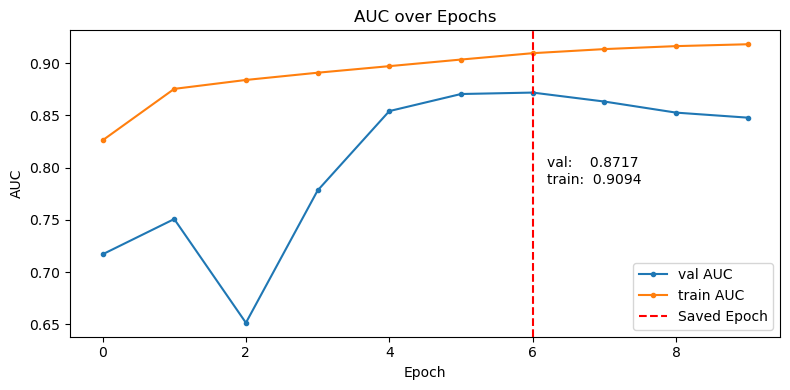

In [18]:
epoch = get_saved_epoch(model,history,v_test)
plotAUC(model_history=history,saved_epoch_data=epoch,test_set=v_test)
plt.tight_layout()

In [19]:
def numerate_filename(filepath,separator='_',reference='filesystem',digits=2,limit=100):
    import numpy,os
    filename = os.path.basename(filepath)
    name, ext = os.path.splitext(filename)
    dirpath = os.path.dirname(filepath)
        
    if not reference or reference == 'filesystem':
        loop_condition = lambda filepath : os.path.exists(filepath)
    elif isinstance(reference, (list, tuple, set, dict, numpy.ndarray)):
        loop_condition = lambda filepath : filepath in reference
    else:
        raise Exception(f"Invalid reference type: {type(reference)} -- must be one of ['filesystem', list, tuple, set, dict, numpy.ndarray]")

    n=1
    while loop_condition(filepath):
        filepath = os.path.join(dirpath,f'{name}{separator}{n:0{digits}d}{ext}')
        n += 1
        if n > limit:
            raise Exception(f"Limit of {limit} copies reached for \033[1m{os.path.basename(filepath)}\033[0m")
    return filepath

class ModelPerformance:
    def __init__(self,test_set=v_test):
        self.model_names = []
        self.y_predictions = []
        self.accuracy_scores = []
        self.confusion_matrices = []
        self.test_set = test_set
        self.y_labels,self.y_true_binary,self.X = yX_split(self.test_set)
        
    def evaluate(self,model,model_name=None,overwrite=True):
        if not overwrite:
            if not model_name:
                mdl_num = len(self.model_names) + 1
                model_name = f"model_{mdl_num}"
            
            model_name = numerate_filename(model_name,
                                           reference=self.model_names,
                                           digits='')
    
            self.model_names.append(model_name)
            acc,y_pred,y_true_unary = evaluate_model(model,dataset=self.test_set)
            self.accuracy_scores.append(acc)
            self.y_predictions.append(y_pred)

            cm = confusion_matrix(y_true_unary,y_pred)
            self.confusion_matrices.append(cm)
            
        else:
            if not model_name:
                model_name = self.model_names[-1]
            model_index = self.model_names.index(model_name)
            
            acc,y_pred,y_true_unary = evaluate_model(model,dataset=self.test_set)
            self.accuracy_scores[model_index] = acc
            self.y_predictions[model_index] = y_pred
            
            cm = confusion_matrix(y_true_unary,y_pred)
            self.confusion_matrices[model_index] = cm

    def data(self):
        mdlPERFs = [(acc,cm,ypred) for acc,cm,ypred in zip(self.accuracy_scores,self.confusion_matrices,self.y_predictions)]
        return { name : eval_data for name,eval_data in zip(self.model_names, mdlPERFs) }

    def plotCM(self,model_name_input=None):
        ncmdict = {name:cm for name,cm in zip(self.model_names,self.confusion_matrices)}

        if not model_name_input:
            model_name_list = self.model_names
        elif isinstance(model_name_input,(list,tuple,dict,np.ndarray)):
            model_name_list = list(model_name_input)
        elif type(model_name_input) == str:
            model_name_list = [model_name_input]
        else:
            raise ValueError(f"Invalid model_name_input {type(model_name_input)}")

        fig,ax = plt.subplots(1,len(model_name_list))
        
        for i,name in enumerate(model_name_list):
            if len(model_name_list) <= 1:
                axf = ax
            else:
                axf = ax.flat[i]
            axf.set_title(name)
            cm_disp = ConfusionMatrixDisplay(ncmdict[name],display_labels=np.unique(self.y_labels))
            cm_disp.plot(ax = axf) 
            


In [20]:
mperf = ModelPerformance()
mperf.evaluate(model,'model_1',overwrite=False)

In [21]:
def plotConfusionMatrix(test_set, load_y=None,
                        model=model, exclude_generic_title=False,
                        display_labels=['Normal','Glaucoma'], 
                        normalize=None, round_prec=2, ax=None, 
                        cmap=plt.cm.cividis, colorbar=True):

    if not load_y:
        _,y_test,X_test = yX_split(test_set)
        y_prob = model.predict(X_test.load())
        y_pred = (y_prob >= 0.5).astype(int)[:,0]
        y_true = np.asarray(y_test).astype(int)[:,0]
    else:
        y_true,y_pred = load_y

    cm = confusion_matrix(y_true, y_pred, labels=[0,1], normalize=normalize)

    if not ax:
        fig,ax = plt.subplots(1,1)

    if normalize:
        vf=f'.{round_prec}f'
        if normalize == 'true':
            ptext='Row-Normalized'
        elif normalize == 'pred':
            ptext='Column-Normalized'
        elif normalize == 'all':
            ptext='Normalized'
        else:
            raise ValueError("normalize : {\'true\', \'pred\', \'all\'}")
    else:
        ptext='Counts'; vf = 'd'
        
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(values_format=vf,
              ax=ax, cmap=cmap, colorbar=colorbar)
    if exclude_generic_title:
        axtitle=ptext
    else:
        axtitle=f'Confusion Matrix ({ptext})'
    ax.set_title(axtitle)

    return ax,cm,(y_true,y_pred)

In [22]:
# Plot confusion matrix for model 1, raw counts & normalized side-by-side

def tandemPlotCountNormCM(test_set, suptitle_addon=None,
                          figsize=(8,4.5), model=model,
                          cmaps = (plt.cm.viridis,plt.cm.cividis)):
    
    fig,axes = plt.subplots(1,2,figsize=figsize, sharey='row')
    
    cm_ax, cm, yload1 = plotConfusionMatrix(test_set, ax=axes[0], 
                                              cmap=cmaps[0], exclude_generic_title=True)
    
    cm_n_ax, cm_n, _ = plotConfusionMatrix(test_set, load_y=yload1, ax=axes[1], normalize='all', 
                                           cmap=cmaps[1], exclude_generic_title=True)
    
    cm_ax.tick_params(axis='y',which='both', rotation=90, left=False)
    cm_n_ax.set_ylabel('')
    cm_n_ax.tick_params(axis='y',which='both', left=False, right=False)

    div = ' - ' if suptitle_addon else ''
    stao = suptitle_addon if suptitle_addon else ''
    suptitle = f"Confusion Matrix{div}{stao}"
    fig.suptitle(suptitle,fontweight='bold',fontsize=15)
    
    plt.tight_layout()

    return cm,cm_n,yload1

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


(222,)

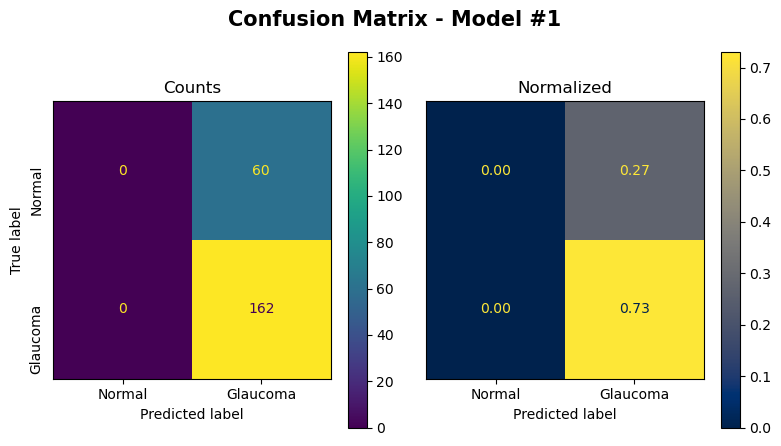

In [23]:
cm1,cm1n,(_,y_pred_1) = tandemPlotCountNormCM(v_test,model=model,suptitle_addon='Model #1')
y_pred_1.shape

As noted during the EDA step, the overall dataset contains contains an unrealistically high proportion of glaucoma compared to the general population -- will keep this in mind for later interpretation / discussion.

### Plotting Class Activation Maps (CAMs) 

##### Example / Walkthrough

In [24]:
{i:layer.name for i,layer in enumerate(model.layers)}

{0: 'conv3d',
 1: 'batch_normalization',
 2: 're_lu',
 3: 'conv3d_1',
 4: 'batch_normalization_1',
 5: 're_lu_1',
 6: 'conv3d_2',
 7: 'batch_normalization_2',
 8: 're_lu_2',
 9: 'conv3d_3',
 10: 'batch_normalization_3',
 11: 're_lu_3',
 12: 'conv3d_4',
 13: 'batch_normalization_4',
 14: 're_lu_4',
 15: 'global_average_pooling3d',
 16: 'dense'}

The last convolutional layer, `'conv3d_4'`, ultimately has outputs in the `re_lu_4` layer (index 14).

In [25]:
inputs = model.layers[0].input
inputs

<KerasTensor shape=(None, 64, 128, 64, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor>

In [26]:
outputs = model.layers[14].output
outputs

<KerasTensor shape=(None, 32, 64, 32, 32), dtype=float32, sparse=False, ragged=False, name=keras_tensor_15>

The `keras.src.backend.common.keras_tensor` objects that are the `.input` and `.output` attributes of the respective model layers are "Symbolic tensors" that "encapsulate a shape and dtypy" per the documentation.  In other words, it simply has information on what the inputs to the whole model looked like (in this case, the input volumes were loaded as tensors of floats with shape (None,64,128,64,1), and the output tensor of the last layer, after passing through the ReLU activation function, is a tensor of floats with shape (None, 32, 64, 32, 32).

Placing the input and output tensor information into `kerasModel()` (`keras.src.models.model`) returns a `keras.src.models.functional` object.

In [27]:
lastConv = kerasModel(inputs,outputs)
lastConv

<Functional name=functional_1, built=True>

But this functional module does not currently have any trained weights in it, just the framework for applying the last convolutional layer.  We get the final dense weights from the absolute last / dense layer:

In [28]:
final_dense_weights = model.layers[-1].weights[0].numpy()
final_dense_weights.shape

(32, 2)

The `final_dense_weights` is an array with columns corresponding to the output classes.  In this case, for binary classification using softmax activation, we passed in `2` for the number of classes in the dense layer:

```python
Dense(2, activation='softmax')
```
So we can subset accordingly:

```python
final_dense_weights[:,0]
```
should refer to weights for the `"healthy"` class, while

```python
final_dense_weights[:,1]
```
should refer to weights for the `"glaucoma"` class.

In [29]:
final_dense_weights[:,0]

array([ 0.19040176, -0.28223822,  0.18221603,  0.132754  ,  0.3674881 ,
        0.05328943, -0.38750848, -0.28294584,  0.02515665,  0.38089243,
       -0.22710377,  0.41293028,  0.2864535 ,  0.10014811,  0.26964414,
       -0.04091386,  0.22745204, -0.13308889, -0.01670774, -0.3769527 ,
        0.29773316,  0.24527119, -0.08761419, -0.21313968, -0.40469563,
       -0.24673702,  0.10404885, -0.0043439 , -0.3922701 ,  0.10567553,
        0.4293084 , -0.36300847], dtype=float32)

In [30]:
final_dense_weights[:,1]

array([-0.42644936,  0.05373909, -0.4228645 , -0.22897594, -0.4204488 ,
       -0.19905907,  0.2939708 ,  0.3834556 ,  0.3786515 ,  0.38461992,
        0.2709098 , -0.21242343,  0.10015564,  0.2688004 , -0.36893022,
       -0.338608  , -0.24590929,  0.27299213,  0.29004475,  0.27845067,
        0.0468367 , -0.17089246,  0.3346235 ,  0.10781143, -0.33131948,
        0.25709552, -0.10325843, -0.11269163,  0.01700896, -0.01176078,
       -0.04148398, -0.3024676 ], dtype=float32)

Ultimately, convolving such linear arrays with a given input volume array should yield the class activation map of such volume.

In [31]:
# Load image array based on index
index=0
if index < len(vX_test.filepaths):
    sample_volume = vX_test.load()[index]
sample_volume.shape

(64, 128, 64, 1)

In [32]:
# Add axis
sample_volume = sample_volume[np.newaxis,...]
sample_volume.shape

(1, 64, 128, 64, 1)

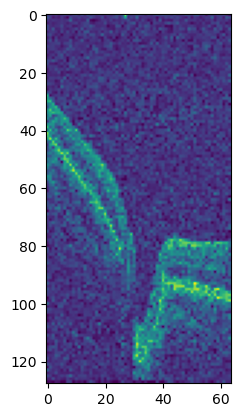

In [33]:
_ = plt.imshow(sample_volume[0,32,:,:,0])

In [34]:
# Pass the volume array into the lastConv() functional module
fmap = lastConv(sample_volume)

In [35]:
print(len(fmap),type(fmap))
print(len(fmap[0]),type(fmap[0]))
print(len(fmap[0][0]),type(fmap[0][0]))
print(len(fmap[0][0][0]),type(fmap[0][0][0]))
print(len(fmap[0][0][0][0]),type(fmap[0][0][0][0]))
try:
    print(len(fmap[0][0][0][0][0]),type(fmap[0][0][0][0][0]))
except:
    print(fmap[0][0][0][0][0])

1 <class 'tensorflow.python.framework.ops.EagerTensor'>
32 <class 'tensorflow.python.framework.ops.EagerTensor'>
64 <class 'tensorflow.python.framework.ops.EagerTensor'>
32 <class 'tensorflow.python.framework.ops.EagerTensor'>
32 <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(0.0, shape=(), dtype=float32)


This can then be converted back into a numpy array at various subsetted levels using the `.numpy()` method of tensorflow.

In [36]:
print(fmap.numpy().shape)
print(fmap[0].numpy().shape)
print(fmap[0][0].numpy().shape)
print(fmap[0][0][0].numpy().shape)
print(fmap[0][0][0][0].numpy().shape)
print(fmap[0][0][0][0][0].numpy().shape)

(1, 32, 64, 32, 32)
(32, 64, 32, 32)
(64, 32, 32)
(32, 32)
(32,)
()


In [37]:
fmap.numpy().shape

(1, 32, 64, 32, 32)

In [38]:
# Subsetting at the first order/level and converting to a numpy array yields a 4D array:
featMaps = fmap[0].numpy()
featMaps.shape

(32, 64, 32, 32)

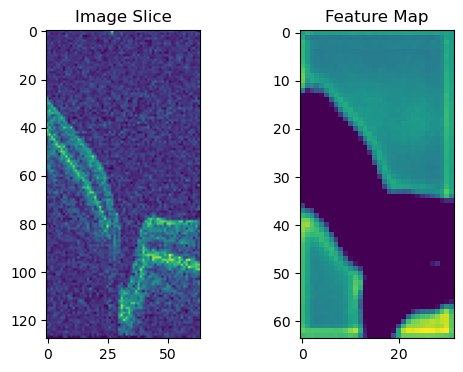

In [39]:
_,(im,fm) = plt.subplots(1,2,figsize=(6,4))
im.imshow(sample_volume[0,32,:,:,0])
im.set_title('Image Slice')
fm.set_title('Feature Map')
_ = fm.imshow(fmap.numpy()[0,16,:,:,0])

Applying the last convolution to the image "blurrs" the image, resulting in a feature map - i.e., image that retains the broad/key features of the original.

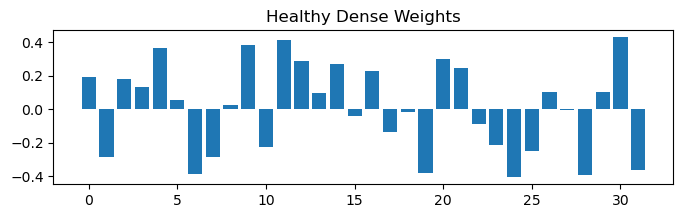

In [40]:
healthy_weights = final_dense_weights[:,0]
hdw_fig = plt.figure(figsize=(8,2))
hdw_title = plt.title('Healthy Dense Weights')
hdw_plot = plt.bar(range(32),height=healthy_weights)

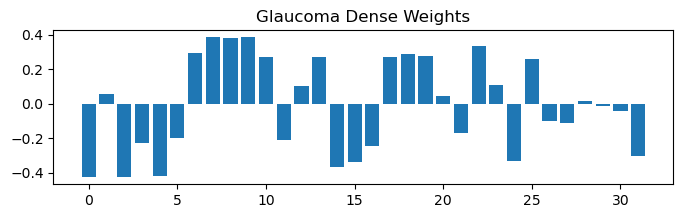

In [41]:
glaucoma_weights = final_dense_weights[:,1]
hdw_fig = plt.figure(figsize=(8,2))
hdw_title = plt.title('Glaucoma Dense Weights')
hdw_plot = plt.bar(range(32),height=glaucoma_weights)

In [42]:
# Applying the two different weights to the feature map via dot product produces the CAMs for each class
healthy_cam = np.tensordot(featMaps,healthy_weights,axes=([3],[0]))
glaucoma_cam = np.tensordot(featMaps,glaucoma_weights,axes=([3],[0]))

In [43]:
healthy_cam.shape, glaucoma_cam.shape

((32, 64, 32), (32, 64, 32))

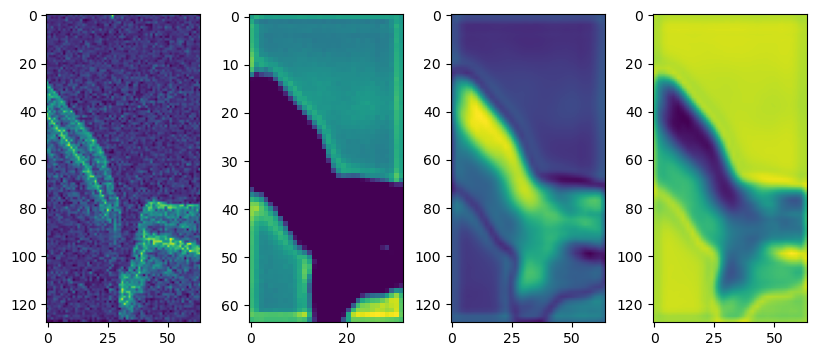

In [44]:
from scipy.ndimage import zoom
zoomcam = lambda cam : zoom(cam,zoom=(2,2,2),order=1)
zoomcam(healthy_cam).shape
_,ax = plt.subplots(1,4,figsize=(10,4))
ax[0].imshow(sample_volume[0,32,:,:,0])
ax[1].imshow(fmap.numpy()[0,16,:,:,0])
ax[2].imshow(zoomcam(healthy_cam)[32,:,:])
ax[3].imshow(zoomcam(glaucoma_cam)[32,:,:])

In [45]:
sample_volume[0,:,:,:,0].shape

(64, 128, 64)

##### Function for Plotting CAMs 

In [46]:
# Function for calculating feature map and CAMs for both classes
def calcFMandCAM(vol_index,df=v_test,model=model):
    # Get last Conv layer from model
    inputs = model.layers[0].input
    outputs = [l for l in model.layers if l.name.startswith('re_lu')][-1].output # i.e., before Dense, GAP --> ReLU of the last Conv3D layer
    lastConv = kerasModel(inputs,outputs)

    # Obtain volume array via vol_index param
    _, _, X = yX_split(df)
    volume = X.load(normalized=True)[vol_index] # NORMALIZED volume
    volume = volume[np.newaxis,...] # Add back dimension for batch_size even though it is 1 in this case
    fmap = lastConv(volume) # Convolve the volume array -- this returns a tensorflow EagerTensor
    featMap = fmap[0].numpy() # Convert back to numpy array

    # Obtain final weights of dense layer from model
    final_dense_weights = model.layers[-1].weights[0].numpy()

    # Subset into class 0 ("-ive for Glaucoma" i.e. Normal) and class 1 ('+ive for Glaucoma' i.e. Glaucoma) weights
    healthy_weights = final_dense_weights[:,0]
    glaucoma_weights = final_dense_weights[:,1]

    # Compute tensor dot product / apply weights to the feature map / convolved volume  array
    hCAM = np.tensordot(featMap,
                              healthy_weights,
                              axes=([3],[0]))
    gCAM = np.tensordot(featMap,
                               glaucoma_weights,
                               axes=([3],[0]))

    return featMap, hCAM, gCAM

In [47]:
# Function for plotting volume slices and the corresponding slices of the feature map, healthy CAM , and glaucoma CAM
def plotFMandCAMslice(vol_index, df=v_test, model=model,
                       axis_norm=0, slice_depth=0.5,
                       figsize=(10,3),cmap='jet'):

    featMap, hCAM, gCAM = calcFMandCAM(vol_index=vol_index, 
                                               df=df, 
                                               model=model)

    y_labels,_,X = yX_split(df)
    
    # Convert back to regular volume shapes and resize to full as needed for viewing
    from scipy.ndimage import zoom
    volume = X.load(normalized=False)[vol_index] #DISPLAY volume
    volume = volume[:,:,:,0]
    featMap = featMap[:,:,:,16]
    featMap = zoom(featMap,zoom=(2,2,2),order=1)
    hCAM = zoom(hCAM,zoom=(2,2,2),order=1)
    gCAM = zoom(gCAM,zoom=(2,2,2),order=1)

    # Extract cross-sections per function params
    vol_slice = crossSection( volume,
                              axis_norm = axis_norm,
                              slice_depth = slice_depth )[0]
    
    fm_slice = crossSection( featMap,
                             axis_norm=axis_norm,
                             slice_depth=slice_depth )[0]
    
    hcam_slice = crossSection( hCAM,
                               axis_norm=axis_norm,
                               slice_depth=slice_depth )[0]
    
    gcam_slice = crossSection( gCAM,
                               axis_norm=axis_norm,
                               slice_depth=slice_depth )[0]  
    
    # print(vol_slice.shape,fm_slice.shape,hcam_slice.shape,gcam_slice.shape)
    
    fig,ax = plt.subplots(1,4,figsize=figsize)
    target_label = y_labels[vol_index]
    ax[0].set_title(f"dx_class: {target_label}")
    ax[0].imshow(vol_slice)
    ax[1].set_title('Feature Map')
    ax[1].imshow(fm_slice)
    ax[2].set_title('Normal-CAM')
    # ax[2].imshow(hcam_slice)#,cmap='jet')
    ax[2].imshow(hcam_slice,cmap=cmap)
    ax[3].set_title('Glaucoma-CAM')
    # ax[3].imshow(gcam_slice)#,cmap='jet')
    ax[3].imshow(gcam_slice,cmap=cmap)
    
    return fig

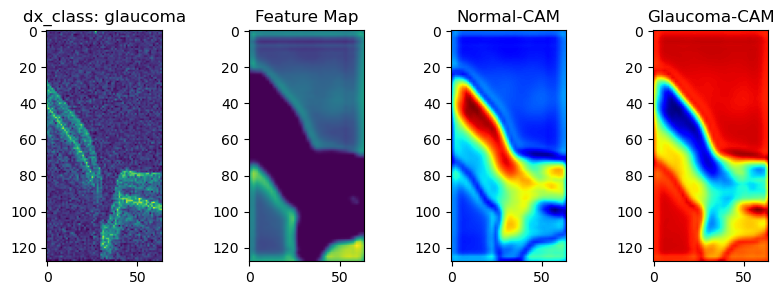

In [48]:
_ = plotFMandCAMslice(0)

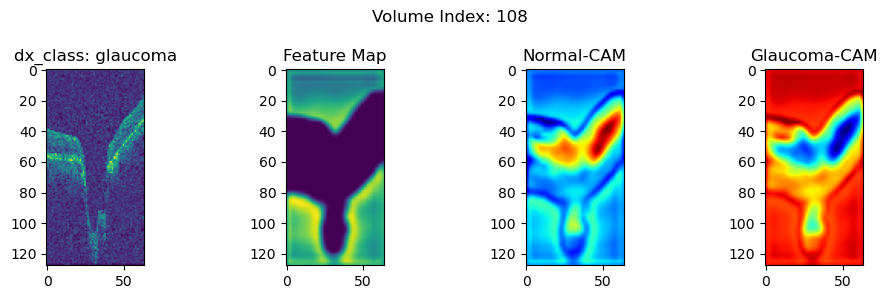

In [49]:
volidx = np.random.randint(0,len(v_test))
fig = plotFMandCAMslice(volidx)
fig.suptitle(f"Volume Index: {volidx}")
plt.tight_layout()

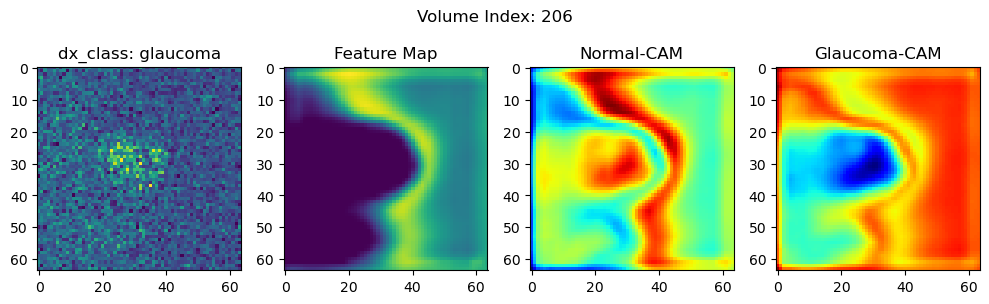

In [50]:
volidx = np.random.randint(0,len(v_test))
fig = plotFMandCAMslice(volidx, axis_norm=1)
fig.suptitle(f"Volume Index: {volidx}")
plt.tight_layout()

Text(0.5, 0.98, 'Volume Index: 163')

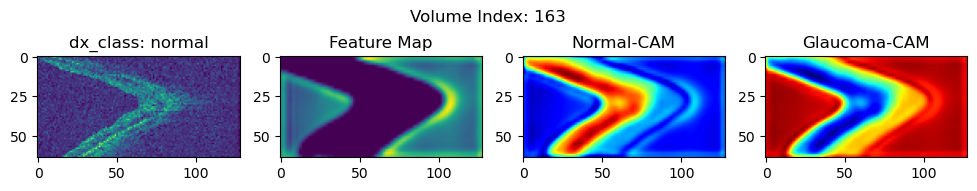

In [51]:
volidx = np.random.randint(0,len(v_test))
fig = plotFMandCAMslice(volidx, axis_norm=2, figsize=(12,2))
fig.suptitle(f"Volume Index: {volidx}")

##### Class Activation Map Vizualization 

In [52]:
# # n rows by 3 cols
# def flatMap(nrows,ncols,opf='dict'):
#     rowIndices = [ r for r in range(nrows) ]
#     colIndices = [ c for c in range(ncols) ]
#     nflat = nrows * ncols
#     flatIndices = [ f for f in range(nflat) ]
#     fMap = []
#     ci = 0
#     ri = 0 
#     for fi in flatIndices:
#         item = (fi,(ri,ci))
#         fMap.append(item)
#         ci += 1
#         if ci == ncols:
#             ci = 0
#             ri += 1

#     if opf == 'basic':
#         return fMap
#     elif opf == 'dict':
#         return dict(fMap)
#     elif opf == 'df':
#         return pd.DataFrame(dict(fMap))
#     elif opf == 'tvfn': #two-variable function of r,c
#         def tvfn(row,col):
#             fiMatches = [ k for k,(r,c) in dict(fMap).items() if r==row and c==col ]
#             if len(fiMatches) == 1:
#                 return fiMatches[0]
#         return tvfn
        
        

# tvfn = flatMap(111,3,opf='tvfn')

# tvfn(3,0)

In [53]:
# def plotCAM(sample=0, classIndex=1, model=model,ax=None):
#     from keras import Model as kerasModel
    
#     if type(sample) == int:
#         if sample < len(vX_test_paths):
#             sample = load_images(vX_test_paths)[sample][np.newaxis,...]
#     lastConv = kerasModel(
#         inputs=model.layers[0].input,
#         outputs=model.layers[-3].output
#     )
    
#     finDenseWts = model.layers[-1].weights[0].numpy()
    
#     featMaps = lastConv(sample)
#     featMaps = featMaps[0].numpy()
    
#     cam = np.tensordot(featMaps, finDenseWts[:,classIndex],axes=([3],[0]))
    
#     if ax:
#         ax.imshow(np.max(cam, axis=0), cmap='jet')
#     else:
#         plt.imshow(np.max(cam, axis=0), cmap='jet')
#         plt.title("Class Activation Map (CAM)")
#         plt.colorbar()



# viran = range(10,15)
# # viran = np.random.choice(range(111),size=5,replace=False)
# # viran.sort()
# # viran = list(viran)

# nvols = len(viran)
# ncols = 3

# fm = flatMap(nvols,ncols=ncols,opf='dict')
# tvfn = flatMap(nvols,ncols=ncols,opf='tvfn')


# fig,axs = plt.subplots(nvols,ncols,figsize=(8,14))
# axes = axs.flatten()
# colTitles = "Normal-CAM POAG-CAM Image".split(' ')
# for j,title in enumerate(colTitles):
#     axs[0,j].set_title(title)
# for vi in viran:
#     i = viran.index(vi)
#     plotCAM(vi, classIndex=0, ax=axes[tvfn(i,0)])
    
#     plotCAM(vi, classIndex=1, ax=axes[tvfn(i,1)])
#     axes[tvfn(i,2)].imshow(load_images(vX_test_paths,normalized=False)[vi].squeeze()[32,:,:])
#     # fig.text(x=.5,y=.5,s='center')

## PART 2: Other Architectures 

##### Original Architecture for Comparision

```python
model = Sequential([

    Input(shape=(64, 128, 64, 1)),
    # Layer 1
    Conv3D(32, kernel_size=7, strides=2, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Layer 2
    Conv3D(32, kernel_size=5, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Layer 3
    Conv3D(32, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Layer 4
    Conv3D(32, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Layer 5
    Conv3D(32, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Global Average Pooling
    GlobalAveragePooling3D(),

    # Dense → Softmax (for multi-class CAM support)
    Dense(2, activation='softmax')  # use 1 + sigmoid if binary
])
```

##### Resnet-Like Architecture

The residual neural network architecture involves "residual blocks" in which the inputs of a convolutional layer are added back to what the output would have normally been to produce the final output.  This produces a "residual connection", i.e. a "skip connection" in which gradients during back-propagation can "traverse."  This is a way to address the "vanishing gradients" problem in deeper networks (more layers), as layers that would have otherwise produced outputs tending towards zero would instead essentially pass the original inputs in unchanged.

In [19]:
def residual_block(x, filters, kernel_size=3, strides=1, activation='relu'):
    shortcut = x
    
    # First convolution
    x = Conv3D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Second convolution
    x = Conv3D(filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Handle potential shape mismatch for the skip connection
    # This occurs when strides > 1
    if strides != 1:
        shortcut = Conv3D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    # Add the skip connection to the main path
    x = Add()([x, shortcut])
    x = ReLU()(x)
    
    return x

This residual blocks can then be chained together in a modular fashion.  In this case, we will try three blocks following an initial regular convolutional layer (no skip connection):

In [18]:
# This code uses the functional API to construct the full model by chaining the residual blocks together.
def build_resnet_like_model(input_shape=(64, 128, 64, 1), num_classes=2):
    inputs = Input(shape=input_shape)
    
    # Initial layer: reduced filters and larger kernel
    x = Conv3D(16, kernel_size=5, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Residual Block 1: No change in spatial dimensions
    x = residual_block(x, filters=16, strides=1)
    
    # Residual Block 2: Reduce spatial dimensions with stride 2
    x = residual_block(x, filters=32, strides=2)
    
    # Residual Block 3: No change in spatial dimensions
    x = residual_block(x, filters=32, strides=1)

    # Global Average Pooling
    x = GlobalAveragePooling3D()(x)
    
    # Dense layer for classification
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create and return the model
    model = kerasModel(inputs, outputs)
    return model

In total, this will make for 7 total convolutional layers (1 regular initial layer, and two layers nested within each of the three residual blocks), which is two more than the original simple sequential architecture.  However, the residual blocks of the ResNet architecure generally allow for more layers under the same memory constraints. 

The rest is the same as before, but this time naming the history output differently for later comparison.

In [20]:
# Delete prior models to free up VRAM
model = None; del model; model_2 = None; del model_2; model_3 = None; del model_3

model_2 = build_resnet_like_model()

# Configure early stopping
early_stop = EarlyStopping(
    monitor='val_auc',
    patience=3,
    restore_best_weights=True
)

# Compile model with Nadam optimizer
model_2.compile(
    optimizer=Nadam(learning_rate=1e-4),
    metrics=['accuracy',AUC(name='auc')],
    loss='binary_crossentropy'
)

In [21]:
save_architecture_json(model_2,'model_2')

In [ ]:
# Load volumes for 3D CNN training, pass in params including early_stop configs, 
# run fit, and save history for plotting & assessment afterwards
history_2 = model_2.fit(
    vX_train.load(),vy_train, 
    validation_data = (vX_test.load(), vy_test), 
    epochs=100,
    batch_size=8,
    callbacks=[early_stop,checkpoints[1]],
    shuffle=False
)

epoch_2 = get_saved_epoch(model_2,
                          model_history = history_2,
                          test_set = v_test)

Epoch 1/100


I0000 00:00:1760043400.215601   69842 service.cc:152] XLA service 0x781e54030f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760043400.215644   69842 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2025-10-09 16:56:40.292503: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760043400.558448   69842 cuda_dnn.cc:529] Loaded cuDNN version 90700


  7/111 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.2422 - auc: 0.3461 - loss: 1.3796

I0000 00:00:1760043403.867432   69842 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.4542 - auc: 0.4495 - loss: 0.9333 - val_accuracy: 0.7297 - val_auc: 0.7938 - val_loss: 0.5825
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7805 - auc: 0.8566 - loss: 0.5296 - val_accuracy: 0.7297 - val_auc: 0.8049 - val_loss: 0.6014
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8016 - auc: 0.8658 - loss: 0.4907 - val_accuracy: 0.7297 - val_auc: 0.7131 - val_loss: 0.6303
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7996 - auc: 0.8723 - loss: 0.4720 - val_accuracy: 0.7297 - val_auc: 0.6866 - val_loss: 0.6805
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8049 - auc: 0.8780 - loss: 0.4573 - val_accuracy: 0.7297 - val_auc: 0.6837 - val_loss: 0.7334
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.7369 - auc: 0.7962 - loss: 0.5917


In [57]:
mperf.evaluate(model_2,'model_2',overwrite=False)

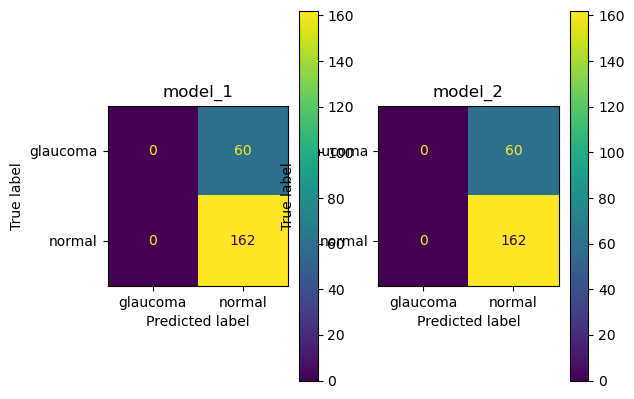

In [58]:
mperf.plotCM()

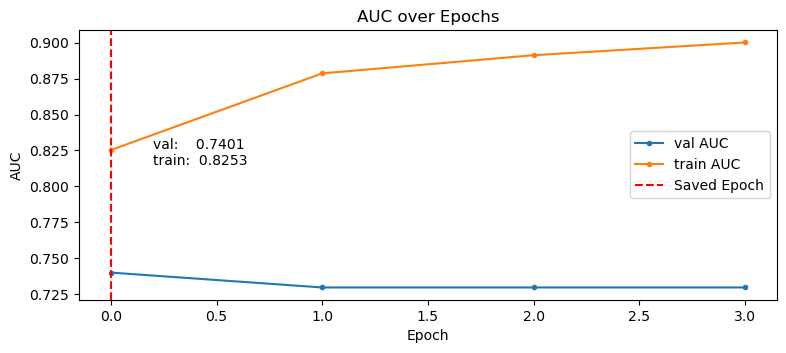

In [59]:
plotAUC(model_history = history_2, 
        saved_epoch_data = epoch_2, 
        test_set = v_test,figsize=(9,3.5))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


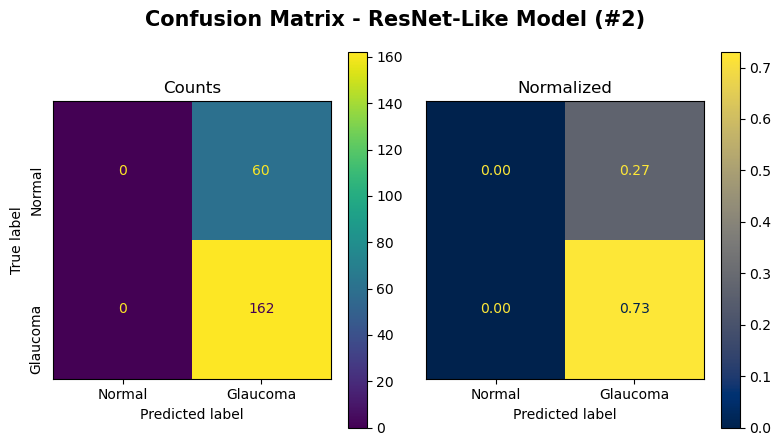

In [60]:
cm2,cm2n,(_,y_pred_2) = tandemPlotCountNormCM(v_test,model=model_2,
                                              suptitle_addon="ResNet-Like Model (#2)")

### Attention: Adding Channel (Squeeze-Excitation) & Spatial Attention to Residual Blocks

In [24]:
def se_block(x, r=16):
    c = x.shape[-1]
    s = layers.GlobalAveragePooling3D()(x)             # (B, C)
    s = layers.Dense(max(c // r, 4), activation='relu')(s)
    s = layers.Dense(c, activation='sigmoid')(s)
    s = layers.Reshape((1, 1, 1, c))(s)
    return layers.Multiply()([x, s])

from keras import ops as K
def spatial_attention(x, k=7):
    """Lightweight spatial attention for 3D (CBAM-style with avg+max)."""
    # channel-wise avg & max → concat → 3D conv → sigmoid mask
    avg = K.mean(x, axis=-1, keepdims=True)
    mx  = K.max(x,  axis=-1, keepdims=True)
    m   = layers.Concatenate(axis=-1)([avg, mx])           # (B,D,H,W,2)
    m   = layers.Conv3D(1, kernel_size=k, padding='same', activation='sigmoid')(m)
    return layers.Multiply()([x, m])


In [25]:
# Updated residual block with option for attention
def residual_block_attn(x, filters, kernel_size=3, strides=1,
                      use_se=True, se_r=16,
                      use_spatial=False, spatial_kernel=7):
    shortcut = x

    # Residual branch
    y = Conv3D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)

    y = Conv3D(filters, kernel_size=kernel_size, padding='same')(y)
    y = BatchNormalization()(y)

    # Optional attention on residual branch *before* addition
    if use_se:
        y = se_block(y, r=se_r)
    if use_spatial:
        y = spatial_attention(y, k=spatial_kernel)

    # Skip path if shape changes
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv3D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    out = Add()([y, shortcut])
    out = ReLU()(out)
    return out


In [26]:
def build_resnet_like_model_attn(input_shape=(64,128,64,1), num_classes=1,
                            use_spatial_last=True):
    inputs = Input(shape=input_shape)

    x = Conv3D(16, kernel_size=5, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Stage 1 (larger maps): SE only
    x = residual_block_attn(x, filters=16, strides=1, use_se=True, use_spatial=False)

    # Stage 2: downsample; SE only
    x = residual_block_attn(x, filters=32, strides=2, use_se=True, use_spatial=False)

    #x = residual_block_attn(x, filters=32, strides=2, use_se=True, use_spatial=False)

    # Stage 3 (smaller maps): SE + optional spatial
    x = residual_block_attn(x, filters=32, strides=1, use_se=True,
                          use_spatial=use_spatial_last, spatial_kernel=7)

    x = GlobalAveragePooling3D()(x)

    outputs = Dense(2, activation='softmax')(x)

    model = kerasModel(inputs, outputs)
    return model

In [27]:
model = None; del model; model_2 = None; del model_2; model_3 = None; del model_3

model_3 = build_resnet_like_model_attn(input_shape=(64,128,64,1), num_classes=2, use_spatial_last=False)

early_stop = EarlyStopping(
    monitor='val_auc', 
    mode='max', 
    patience=3, 
    restore_best_weights=True
)

model_3.compile(
    optimizer=Nadam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

In [28]:
save_architecture_json(model_3,'model_3')

In [ ]:
history_3 = model_3.fit(
    vX_train.load(), vy_train, 
    validation_data=(vX_test.load(), vy_test),
    epochs=100,
    batch_size=8,
    callbacks=[early_stop,checkpoints[2]],
    shuffle=False
)

epoch_3 = get_saved_epoch(model_3,
                          model_history = history_3,
                          test_set = v_test)

Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.7626 - auc: 0.7836 - loss: 0.6215 - val_accuracy: 0.7297 - val_auc: 0.7433 - val_loss: 0.6209
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7679 - auc: 0.8512 - loss: 0.5133 - val_accuracy: 0.7297 - val_auc: 0.6597 - val_loss: 0.6086
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7728 - auc: 0.8630 - loss: 0.4846 - val_accuracy: 0.7297 - val_auc: 0.6715 - val_loss: 0.7070
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7928 - auc: 0.8735 - loss: 0.4668 - val_accuracy: 0.7297 - val_auc: 0.7330 - val_loss: 0.8848
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.7369 - auc: 0.7621 - loss: 0.6177


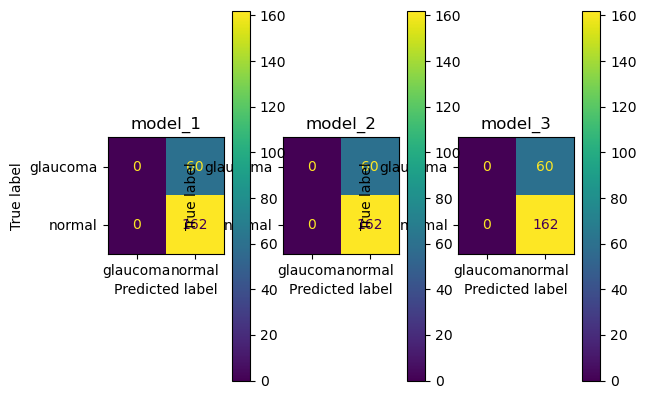

In [65]:
mperf.evaluate(model_3,'model_3',overwrite=False)
mperf.plotCM()

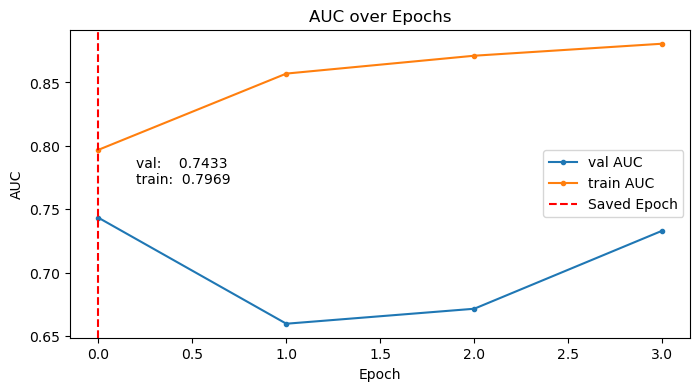

In [67]:
plotAUC(history_3,v_test,epoch_3)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


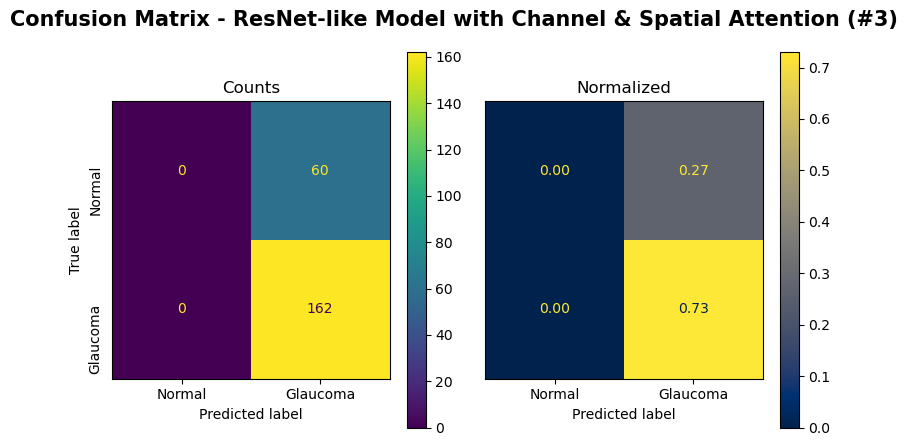

In [68]:
cm3,cm3n,(_,y_pred_3) = tandemPlotCountNormCM(v_test,model=model_3,suptitle_addon='ResNet-like Model with Channel & Spatial Attention (#3)')

In [69]:
acc_3,ypred_3,y_true_3=evaluate_model(model_3,v_test)

In [72]:
# ytCOMP = (ytrue_2 == y_true_3).all()
# ypCOMP = (ypred_2 == ypred_3).all()
# accCOMP = acc_2 == acc_3
# print(ytCOMP,ypCOMP,accCOMP)
# cm3 = confusion_matrix(y_true_3,ypred_3)
# cm2 = confusion_matrix(ytrue_2,ypred_2)
# print('\n',cm2,'\n\n',cm3,'\n')

## Model Performance Summaries

### Training History  

In [ ]:
fig,axes = plt.subplots(3,1,figsize=(8,8),sharex=True)

saved_histories = [history,history_2,history_3]
saved_epochs = [epoch,epoch_2,epoch_3]

for i,(his,ep) in enumerate(zip(saved_histories,saved_epochs)):
    plotAUC(his,v_test,ep,ax=axes[i])
    title = axes[i].get_title()
    axes[i].set_title(f'Model #{i+1}')
    if i < len(saved_epochs)-1:
        axes[i].set_xlabel('')
        axes[i].tick_params(axis='x', bottom=False)
fig.suptitle(title,fontsize=15)
plt.tight_layout()

### Classification Reports

In [ ]:
allreports = []
for i,y_pred in enumerate([y_pred_1,y_pred_2,y_pred_3]):
    iPyDisplay(iPyMD(f'#### Model {i+1}\n---'))
    report = classification_report(y_true=vy_test[:,0],
                                   y_pred=y_pred, 
                                   target_names=['Normal','Glaucoma'],
                                   output_dict=True)
    
    allreports.append(report)
    report_df = pd.DataFrame(report)
    iPyDisplay(report_df) 

### Save Models to File

In [ ]:
model = None; del model
model_2 = None; del model_2
model_3 = None; del model_3

from keras.models import load_model

def eval_saved_model(modelNAME, modelDIR="checkpoints/"):
    modelPATH = os.path.join(modelDIR,modelNAME)
    loaded_model = load_model(modelPATH)
    lmy_prob1 = loaded_model.predict(vX_test.load())
    lmy_pred1 = (lmy_prob > 0.5).astype(int)[:,0]
    correct = (lmy_pred == y_true).sum()
    incorrect = len(y_true) - correct
    accuracy = correct / len(y_true)
    print(accuracy)

for i in range(1,4):
    eval_saved_model(f'model_{i}.keras')


<div class="alert alert-warning alert-dismissible fade show" style="color:magenta">
    
<strong>

## Capstone 3 - Extension

</strong>
    
</div>        

## PART 3: Attempting 2D CNN with Combined Dataset